In [77]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.pipeline import Pipeline


df = load_df()

print(df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
                        datetime  import_capacity  upward_dispatch_published  \
0      2023-12-29 00:00:00+00:00             65.4                        0.0   
1      2023-12-29 00:01:00+00:00             65.4                        0.0   
2      2023-12-29 00:02:00+00:00             65.4                        0.0   
3      2023-12-29 00:03:00+00:00             65.4                        0.0   
4      2023-12-29 00:04:00+00:00             65.4                        0.0   
...                          ...              ...                        ...   
220241 2024-05-29 22:41:00+00:00           1982.6                      167.0   
220242 2024-05-29 22:42:00+00:00           1982.6                      165.0   
220243 2024-05-29 22:43:00+00:00           1982.6                      162.0   
220244 2024-05-29 22:44:00+00:00           1982.6                      158.0   
220245 2024-05-29 22:45:00+00:00

In [78]:
df['residual_load'] = df['forecast_demand'] - df['forecast_solar'] - df['forecast_wind']
df['forecast_solar_delta'] = df['forecast_solar'].diff()
df['forecast_wind_delta'] = df['forecast_wind'].diff()

for i in range(0, len(df), 15):
    df.loc[i+1:i+14, 'forecast_solar_delta'] = df['forecast_solar_delta'][i]
    df.loc[i+1:i+14, 'forecast_wind_delta'] = df['forecast_wind_delta'][i]

# diffs
df['min_price_diff'] = df['min_price_published'].diff()
df['downward_dispatch_diff'] = df['downward_dispatch_published'].diff()
df['igcc_down_diff'] = df['igcc_contribution_down_published'].diff()
df['dispatch_diff'] = df['upward_dispatch_published'] - df['downward_dispatch_published']
df['igcc_diff'] = df['igcc_contribution_up_published'] - df['igcc_contribution_down_published']

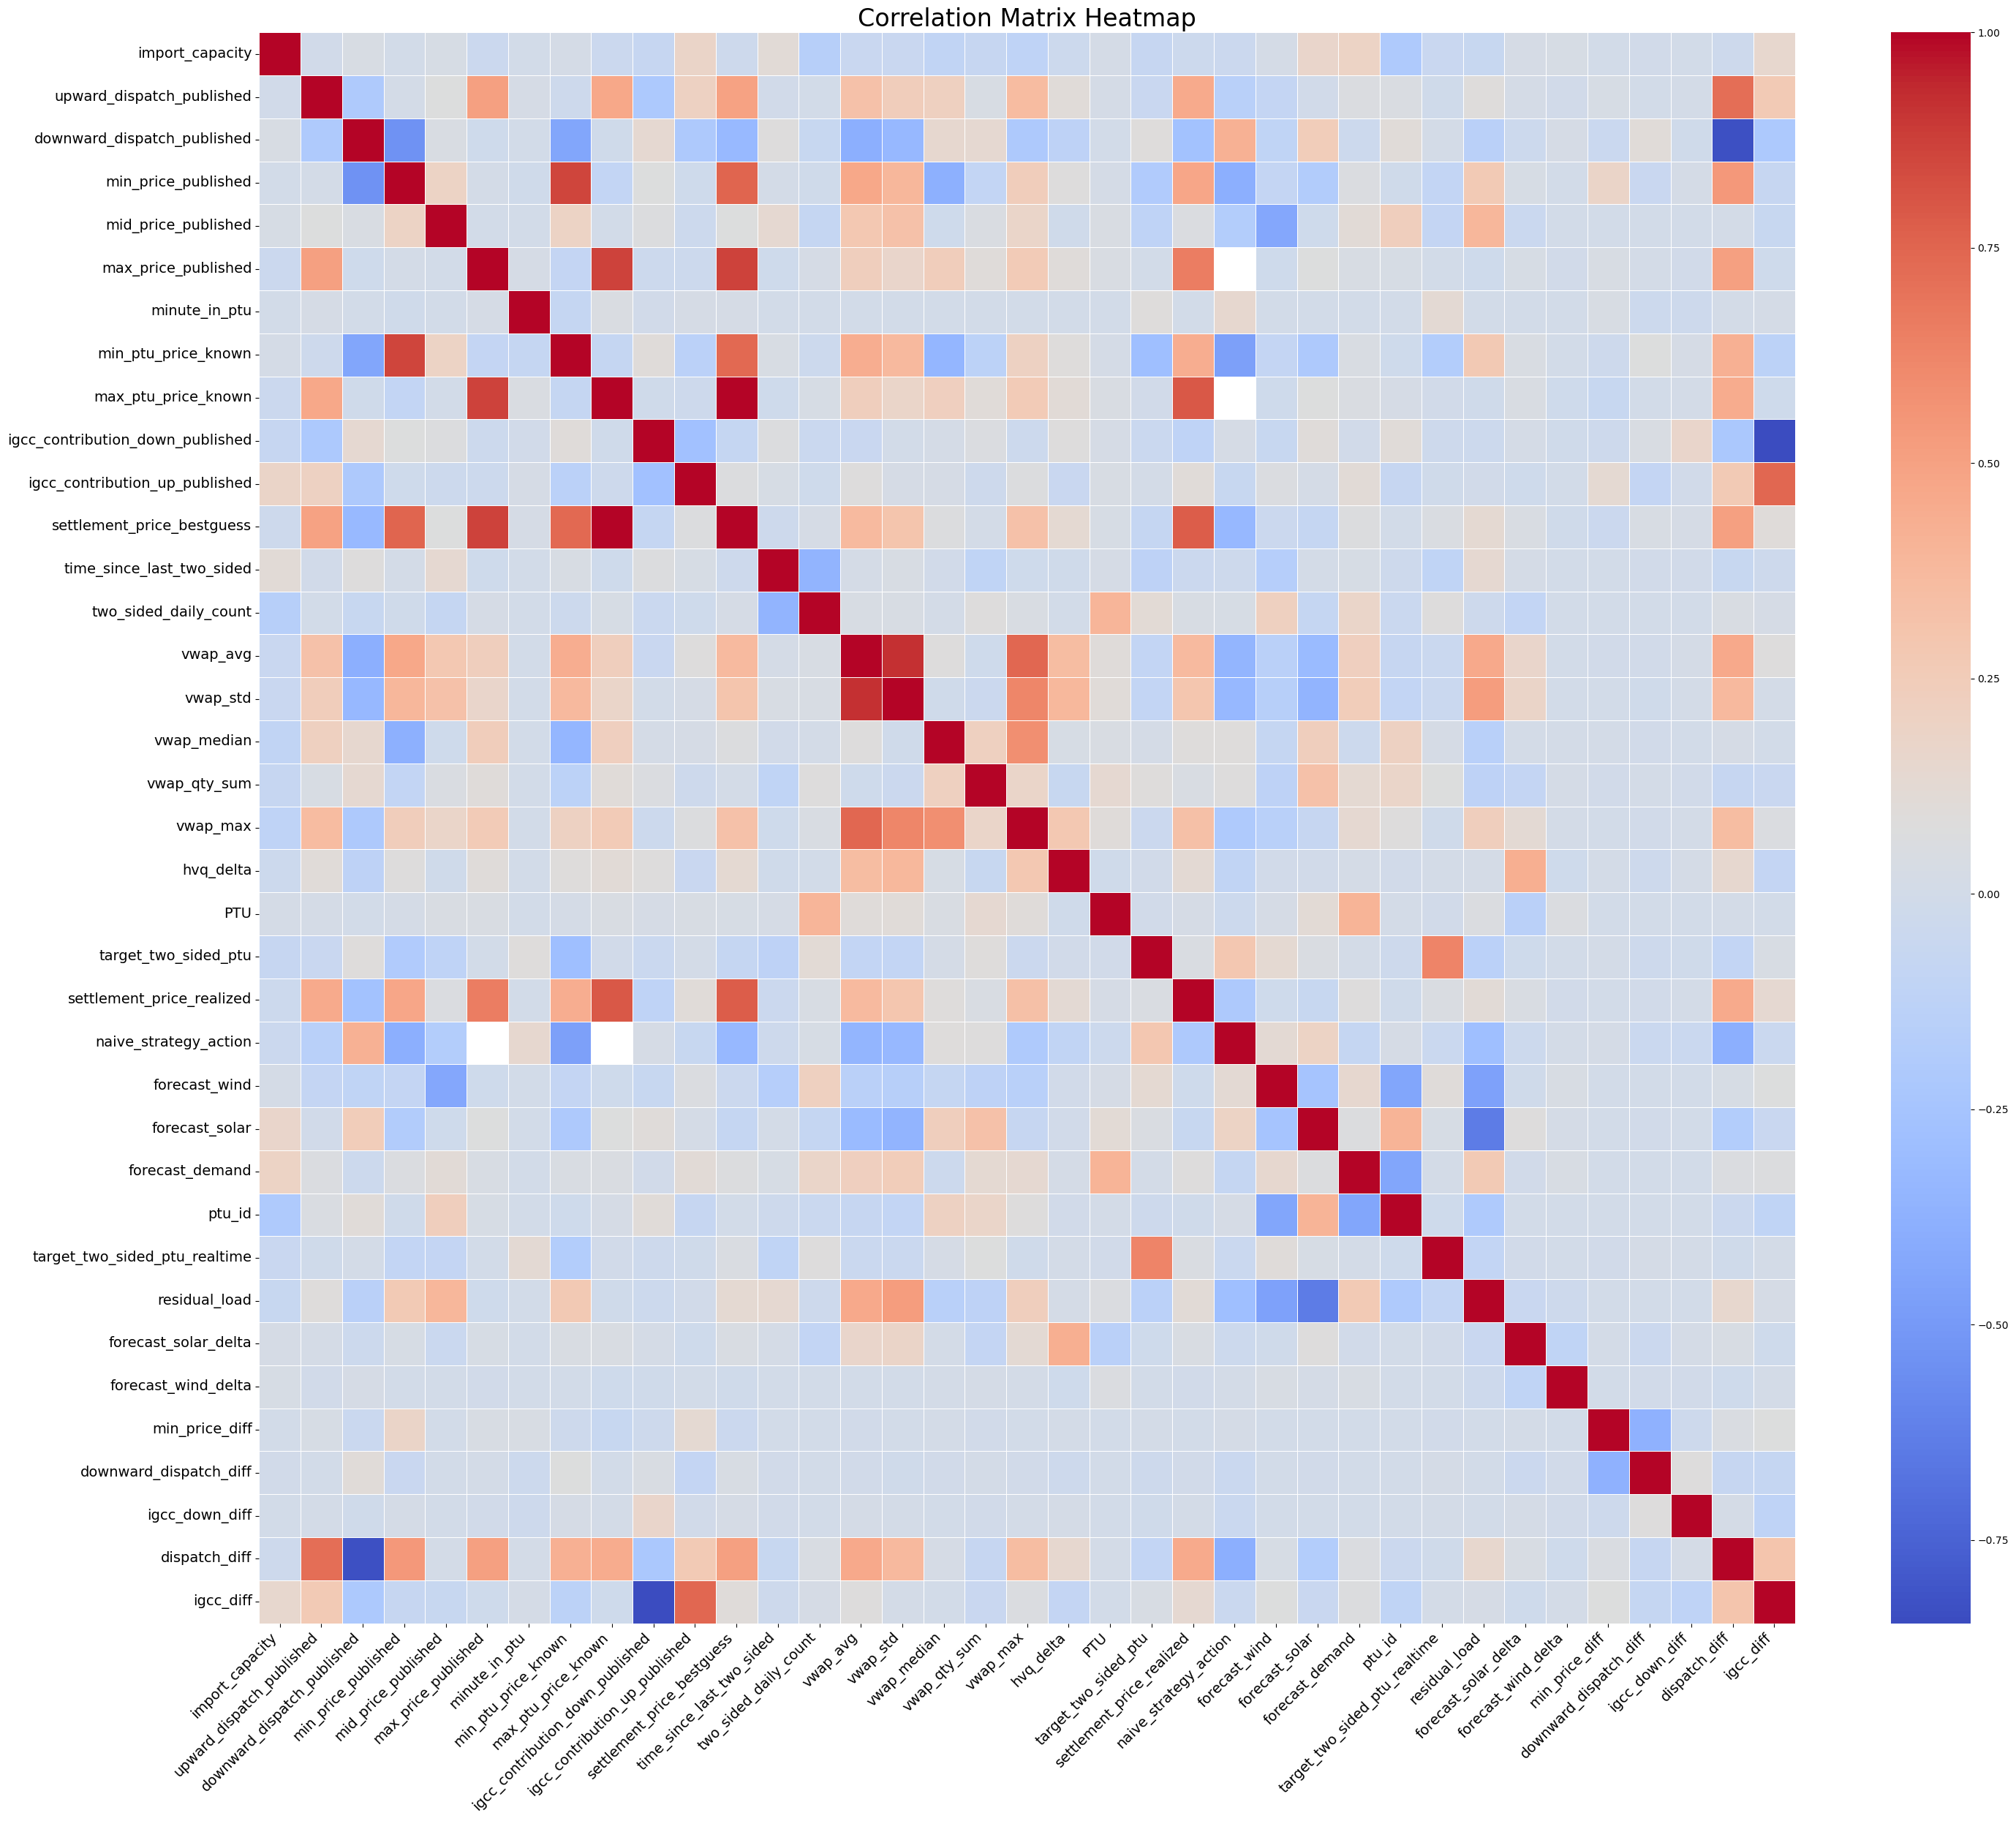

In [79]:
rejected = [
    "target_two_sided_ptu_alt",
    "target_two_sided_ptu_flip",
    "fix_two_sided_ptu",
    "fix_two_sided_ptu_alt",
    "fix_two_sided_ptu_flip",
    "fix_two_sided_ptu_realtime",
    'datetime',
]

features = [col for col in df.columns if col not in rejected]

df_target = df[features]

correlation_matrix = df_target.corr()

# Step 3: Plot the correlation matrix
plt.figure(figsize=(30, 25))
heatmap = sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap', size=24)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()

In [80]:
pipeline = Pipeline([
    ('rfe', RFE(RandomForestClassifier(), n_features_to_select=10))  # select 5 features
])

# Fit the pipeline on the data
pipeline.fit(df_target[~df_target['target_two_sided_ptu']][:150000], df_target['target_two_sided_ptu'][:150000])

# Get the selected features
selected_features = pipeline.named_steps['rfe'].support_

selected_features_mask = pipeline.named_steps['rfe'].support_
selected_column_names = df_target.columns[selected_features_mask]

print("Selected Column Names:", selected_column_names)

Selected Column Names: Index(['mid_price_published', 'minute_in_ptu', 'time_since_last_two_sided',
       'vwap_avg', 'PTU', 'forecast_demand', 'ptu_id', 'residual_load',
       'dispatch_diff', 'igcc_diff'],
      dtype='object')


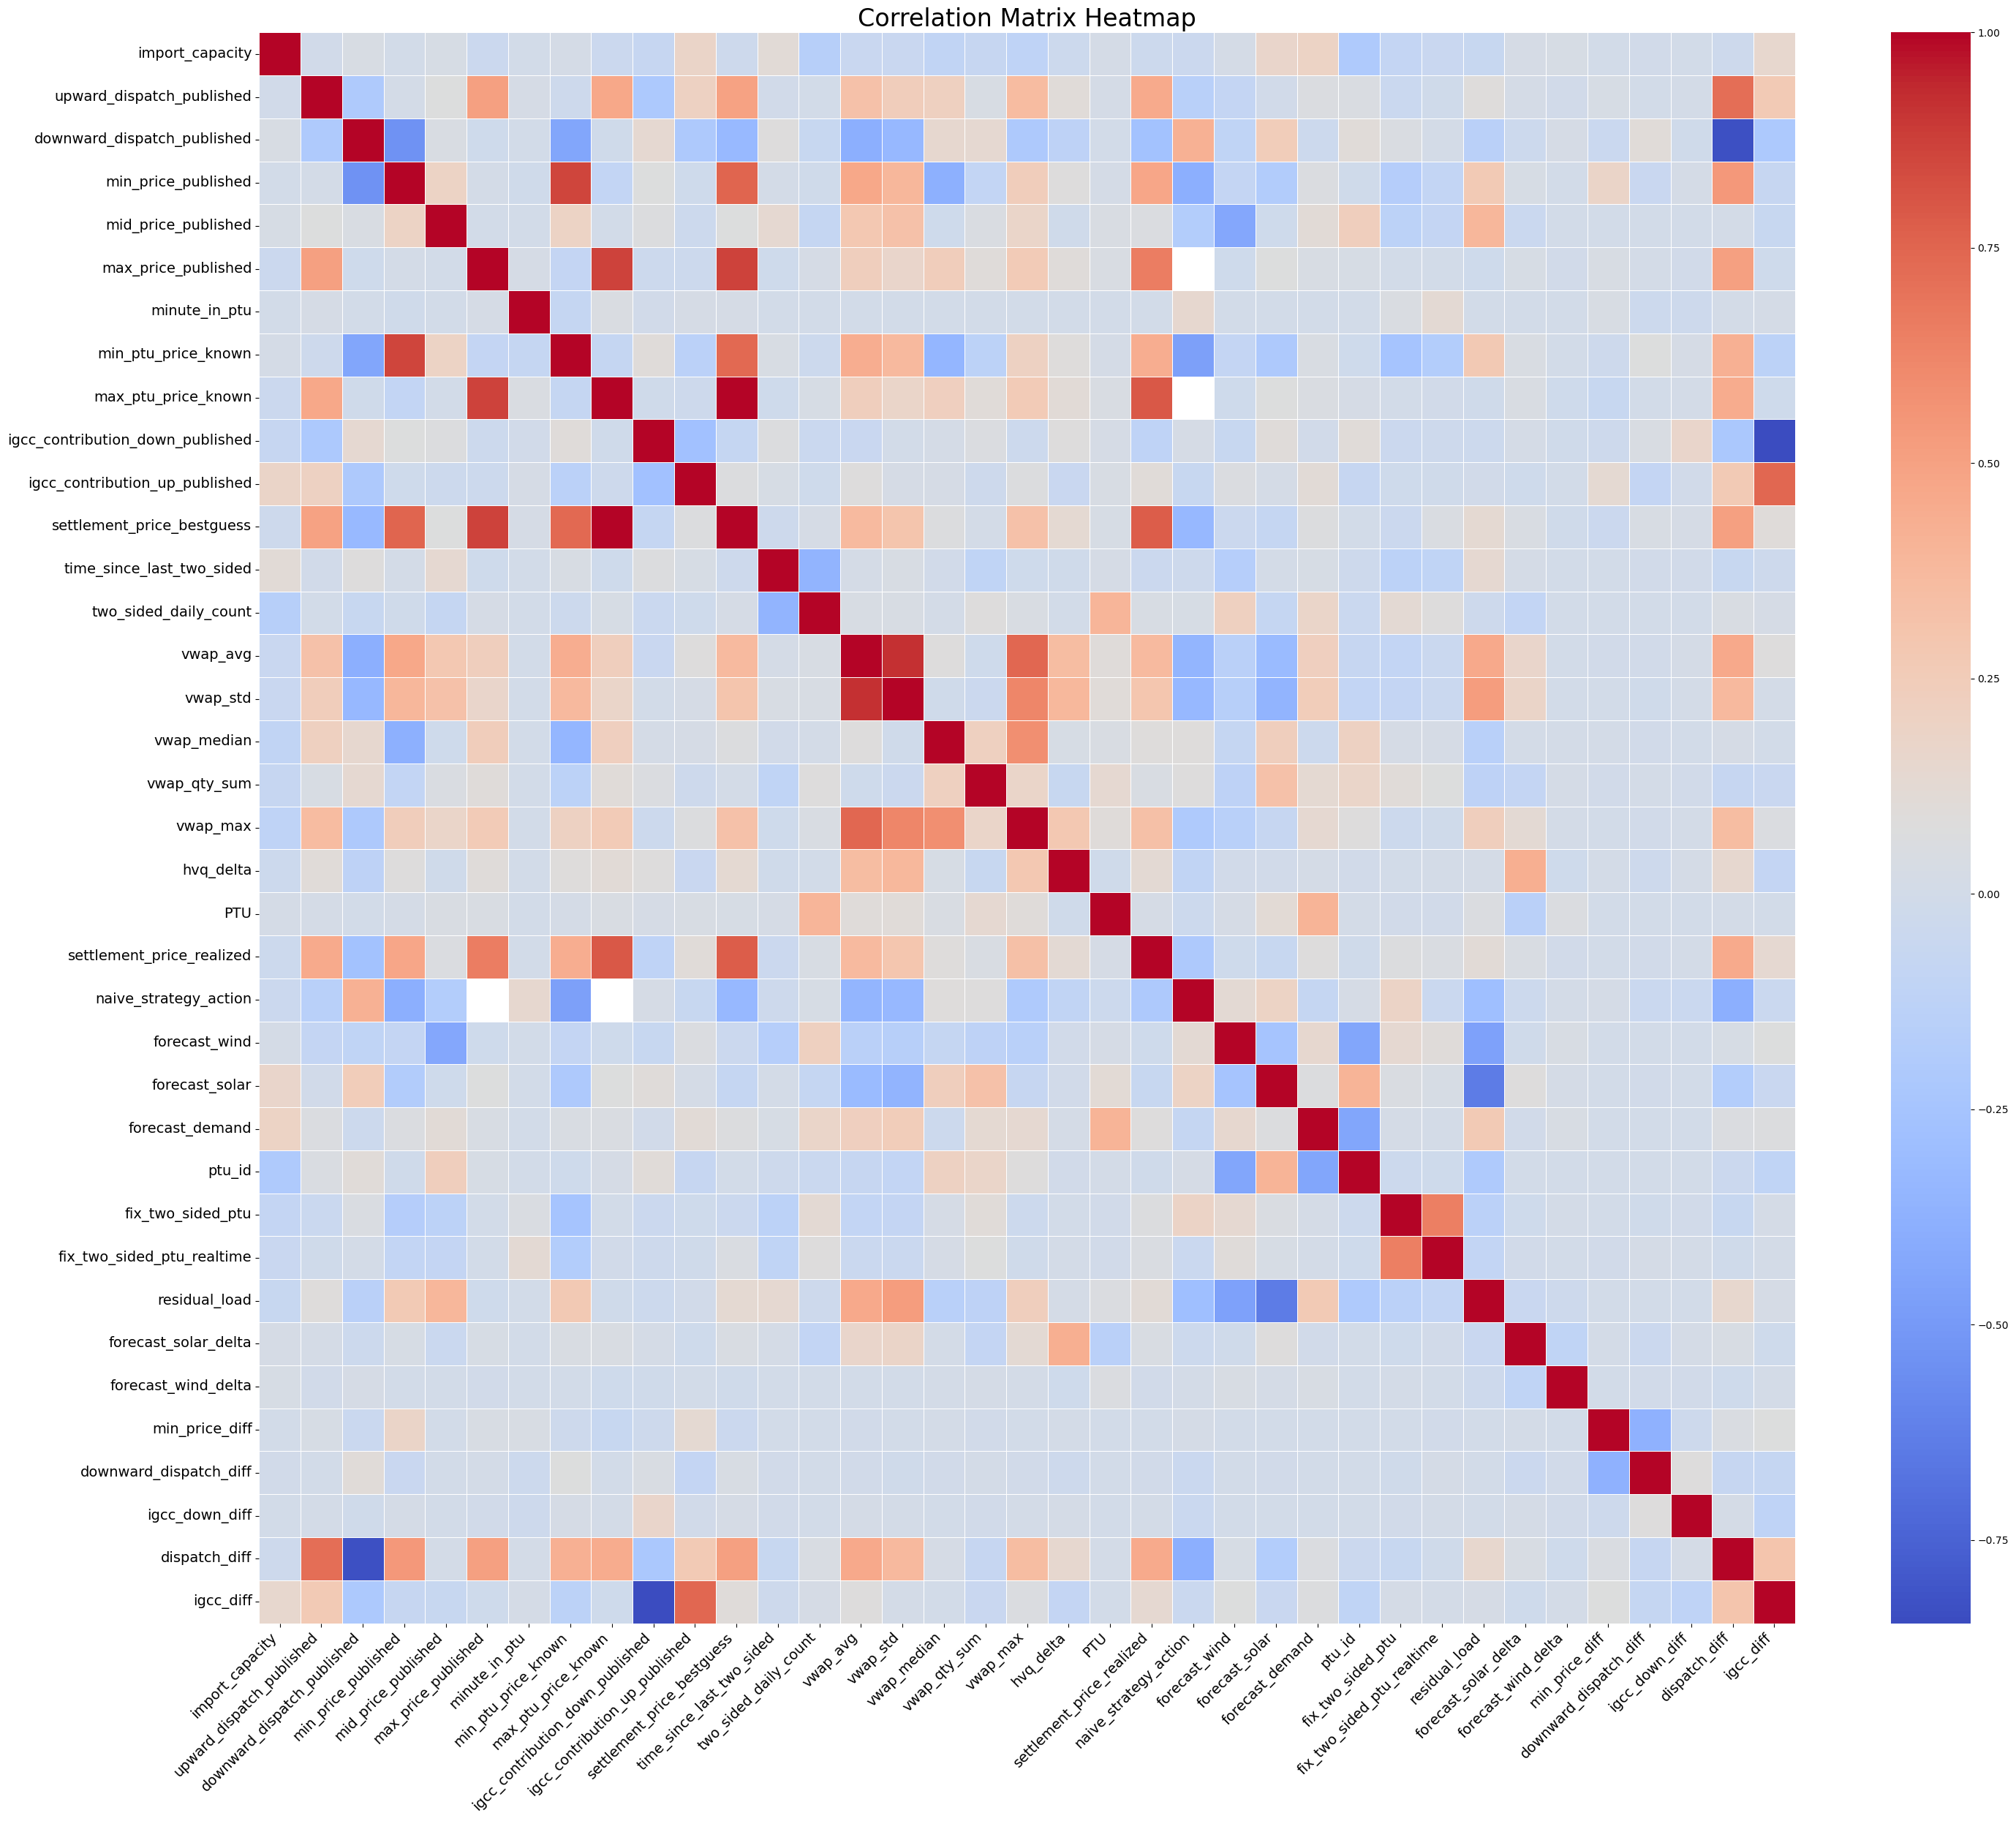

In [81]:
rejected = [
    "target_two_sided_ptu_alt",
    "target_two_sided_ptu_flip",
    "target_two_sided_ptu",
    "target_two_sided_ptu_realtime",
    "fix_two_sided_ptu_alt",
    "fix_two_sided_ptu_flip",
    'datetime',
]

features = [col for col in df.columns if col not in rejected]

df_target = df[features]

correlation_matrix = df_target.corr()

# Step 3: Plot the correlation matrix
plt.figure(figsize=(30, 25))
heatmap = sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap', size=24)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()

In [82]:
pipeline = Pipeline([
    ('rfe', RFE(RandomForestClassifier(), n_features_to_select=10))  # select 5 features
])

# Fit the pipeline on the data
pipeline.fit(df_target[~df_target['fix_two_sided_ptu']][:150000], df_target['fix_two_sided_ptu'][:150000])

# Get the selected features
selected_features = pipeline.named_steps['rfe'].support_

selected_features_mask = pipeline.named_steps['rfe'].support_
selected_column_names = df_target.columns[selected_features_mask]

print("Selected Column Names:", selected_column_names)

Selected Column Names: Index(['mid_price_published', 'minute_in_ptu', 'time_since_last_two_sided',
       'vwap_median', 'PTU', 'forecast_wind', 'forecast_demand', 'ptu_id',
       'residual_load', 'dispatch_diff'],
      dtype='object')
